# Notebook 04 - Package Comparison

*Martin Vonk - 2023*

This notebooks compares the calculated drought indices to other (Python) packages or time series retrieved from other locations.
Current comparisons include: 
* standard_precip (Python)
* climate_indices (Python)
* pastas (Python)

## Required packages

In [1]:
import spei as si
import pastas as ps
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

## Read Precipitation Data

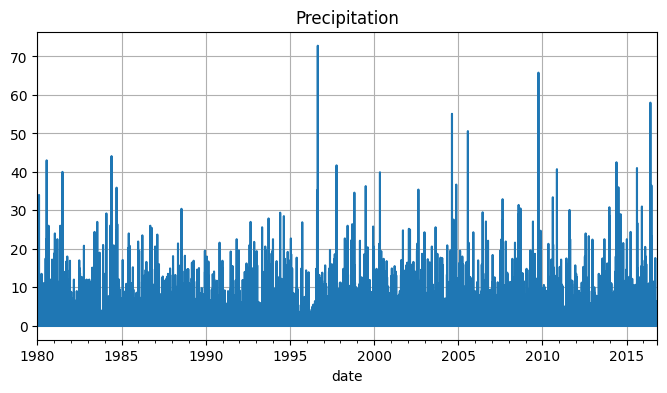

In [2]:
fileurl = "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data"
prec = (
    pd.read_csv(f"{fileurl}/rain_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
prec.plot(grid=True, title="Precipitation", figsize=(8, 4));

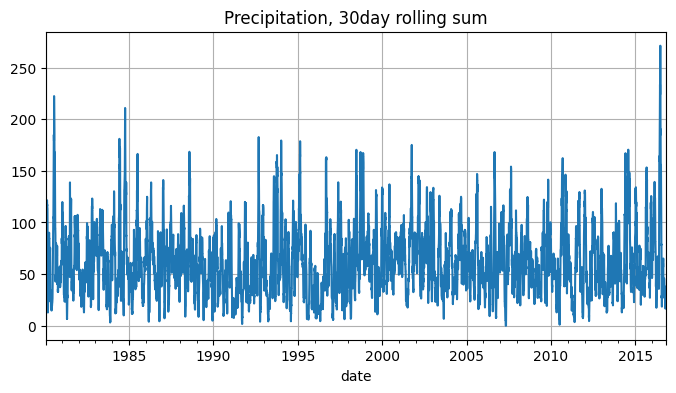

In [3]:
# get rolling sum
prec_rsum = prec.rolling("30D", min_periods=30).sum().dropna()
prec_rsum.plot(grid=True, title="Precipitation, 30day rolling sum", figsize=(8, 4));

## Compute Standardized Precipitation Index

### Using SPEI package

In [4]:
spi = si.spi(prec_rsum, dist=scs.gamma, prob_zero=True)
spi  # pandas Series

date
1980-01-30   -0.946377
1980-01-31   -0.810205
1980-02-01    0.018504
1980-02-02    0.040376
1980-02-03    0.216153
                ...   
2016-10-27   -0.744963
2016-10-28   -0.744963
2016-10-29   -0.732095
2016-10-30   -0.805841
2016-10-31   -0.850192
Length: 13425, dtype: float64

### Using standard_precip package

In [5]:
from standard_precip import spi as sp_spi

# standard_precip also needs rolling sum dataframe, even though you provide freq="M" and scale = 1
precdf = prec_rsum.to_frame().reset_index().copy()

# initialize spi
standardp_spi_inst = sp_spi.SPI()

# caclulate index with many parameters
standardp_spi = standardp_spi_inst.calculate(
    precdf,
    date_col="date",
    precip_cols="rain",
    freq="M",
    scale=1,  # scale is weird naming choice here because that's the same keyword used for the standard deviation in SciPy
    fit_type="mle",
    dist_type="gam",
)
standardp_spi.index = standardp_spi.loc[
    :, "date"
].values  # create datetimeindex because date had to be a column

standardp_spi  # pandas DataFrame

,date,rain,rain_calculated_index
1980-01-30,1980-01-30,43.1,-0.946377
1980-01-31,1980-01-31,46.8,-0.810206
1980-02-01,1980-02-01,56.3,0.018504
1980-02-02,1980-02-02,57.0,0.040376
1980-02-03,1980-02-03,62.8,0.216153
...,...,...,...
2016-10-27,2016-10-27,37.5,-0.744964
2016-10-28,2016-10-28,37.5,-0.744964
2016-10-29,2016-10-29,37.8,-0.732096
2016-10-30,2016-10-30,36.1,-0.805842


### Using climate_indices package

In [6]:
from climate_indices.compute import scale_values, Periodicity
from climate_indices import compute, indices, utils

In [7]:
# this is gonna take a lot of code...
initial_year = prec_rsum.index[0].year
calibration_year_initial = prec_rsum.index[0].year
calibration_year_final = prec_rsum.index[-1].year
period_times = 366
scale = 1
periodicity = compute.Periodicity.daily

values = prec_rsum.values

scaled_values = compute.scale_values(
    values,
    scale=scale,
    periodicity=periodicity,
)

alphas, betas = compute.gamma_parameters(
    scaled_values,
    data_start_year=initial_year,
    calibration_start_year=calibration_year_initial,
    calibration_end_year=calibration_year_final,
    periodicity=periodicity,
)

gamma_params = {"alpha": alphas, "beta": betas}

spival = indices.spi(
    values,
    scale=scale,
    distribution=indices.Distribution.gamma,
    data_start_year=initial_year,
    calibration_year_initial=calibration_year_initial,
    calibration_year_final=calibration_year_final,
    periodicity=compute.Periodicity.daily,
    fitting_params=gamma_params,
)

climateind_spi = pd.Series(spival, index=prec_rsum.index, name="Climate Index SPI")
climateind_spi

date
1980-01-30   -0.350835
1980-01-31   -0.215335
1980-02-01    0.102285
1980-02-02    0.154274
1980-02-03    0.337322
                ...   
2016-10-27   -0.818221
2016-10-28   -0.852997
2016-10-29   -0.843808
2016-10-30   -0.913400
2016-10-31   -1.031608
Name: Climate Index SPI, Length: 13425, dtype: float64

## Plot and compare

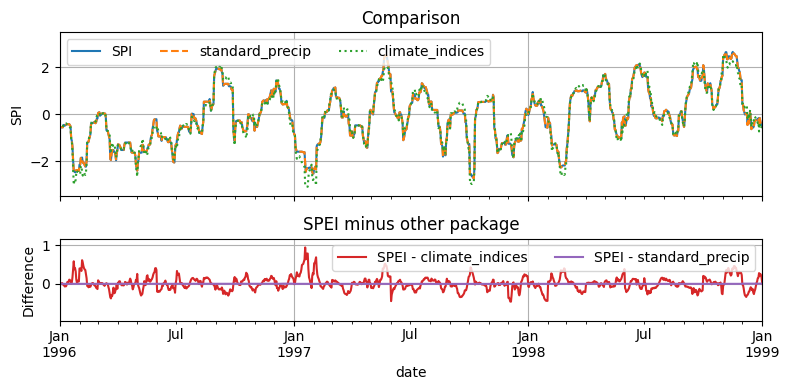

In [8]:
f, ax = plt.subplot_mosaic(
    [["SPI"], ["DIFF"]],
    figsize=(8, 4),
    sharex=True,
    height_ratios=[2, 1],
)
spi.plot(ax=ax["SPI"], grid=True, linestyle="-", label="SPI")
standardp_spi.loc[:, "rain_calculated_index"].plot(
    ax=ax["SPI"],
    color="C1",
    grid=True,
    linestyle="--",
    label="standard_precip",
)
climateind_spi.plot(
    ax=ax["SPI"], color="C2", grid=True, linestyle=":", label="climate_indices"
)

ax["SPI"].set_ylim(-3.5, 3.5),
ax["SPI"].set_title("Comparison"),
ax["SPI"].set_ylabel("SPI"),
ax["SPI"].legend(ncol=3)

(spi - climateind_spi).plot(ax=ax["DIFF"], color="C3", label="SPEI - climate_indices")
(spi - standardp_spi.loc[:, "rain_calculated_index"]).plot(
    ax=ax["DIFF"], color="C4", label="SPEI - standard_precip", grid=True
)
# ax["DIFF1"].set_ylim(-0.05, 0.05)
ax["DIFF"].legend(ncol=2)
ax["DIFF"].set_title("SPEI minus other package")
ax["DIFF"].set_ylabel("Difference")
ax["DIFF"].set_xlim("1996", "1999")
f.tight_layout()

Difference is very small between SPEI an the standard_precip package. However there is a significant difference beteween the SPEI and climate_indices package, not sure why. Maybe it has to do with the fitting method used for the gamma distribution?

The standard_precip package does not explicitely support the Standardized Precipitaion Evaporation Index, as far as I can see. However, the SPI class in standard_precip could probably be used, even though the naming of `precip_cols` is not universal. In general, the standard_precip package needs much more keyword arguments while the SPEI package makes more use of all the nice logic already available in SciPy and Pandas.

The climate_indices package needs even much more code, imo too much. Why can't we keep it nice and simple?

# Compute Standardized Groundwater Index

In [9]:
head = pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/B32C0639001.csv", index_col=0, parse_dates=True).squeeze()

sgi = si.sgi(head)
sgi_pastas = ps.stats.sgi(head)

In [10]:
pd.concat([sgi, sgi_pastas], axis=1).rename(columns={0:"SGI", "head":"Pastas"})

,SGI,Pastas
date,,
1981-07-03,1.101146,1.101146
1981-07-17,0.776422,0.776422
1981-07-30,0.579132,0.579132
1981-08-19,0.154074,0.154074
1981-09-02,-0.282216,-0.282216
...,...,...
2005-07-14,-0.237202,-0.237202
2005-07-28,-0.346234,-0.346234
2005-08-29,-0.791639,-0.791639


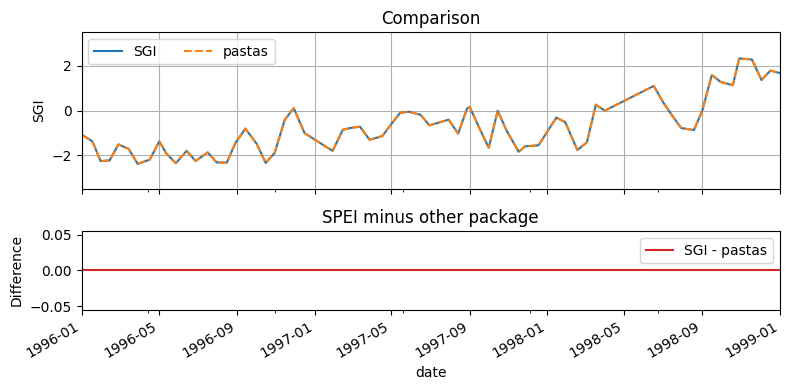

In [11]:
f, ax = plt.subplot_mosaic(
    [["SGI"], ["DIFF"]],
    figsize=(8, 4),
    sharex=True,
    height_ratios=[2, 1],
)
sgi.plot(ax=ax["SGI"], grid=True, linestyle="-", label="SGI")
sgi_pastas.plot(
    ax=ax["SGI"],
    color="C1",
    grid=True,
    linestyle="--",
    label="pastas"
    )
ax["SGI"].set_ylim(-3.5, 3.5),
ax["SGI"].set_title("Comparison"),
ax["SGI"].set_ylabel("SGI"),
ax["SGI"].legend(ncol=3)

(sgi - sgi_pastas).plot(ax=ax["DIFF"], color="C3", label="SGI - pastas")

ax["DIFF"].legend(ncol=2)
ax["DIFF"].set_title("SPEI minus other package")
ax["DIFF"].set_ylabel("Difference")
ax["DIFF"].set_xlim("1996", "1999")
f.tight_layout()